<a href="https://colab.research.google.com/github/edoaurahman/PCVK/blob/main/Week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas Praktikum

Lakukan Face Detection untuk image object lain yang tersedia pada (/images/facedet).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
# import library yang dibutuhkan
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PIL
import io
import html
import time
from base64 import b64decode, b64encode
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js

In [21]:
def detect_face(img_path, classifier = '/content/drive/MyDrive/PCVK_MM/Images/Images/haarcascades/haarcascade_frontalface_alt.xml'):
  cascade_wajah = cv.CascadeClassifier(classifier)
  img = cv.imread(img_path)
  img_copy = img.copy()
  roi_wajah = cascade_wajah.detectMultiScale(img)
  for (x,y,w,h) in roi_wajah:
    cv.rectangle(img_copy, (x,y), (x+w, y+h), (0,255,0), 3)
  plt.figure(figsize=(10,10))
  plt.subplot(121)
  plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.subplot(122)
  plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()

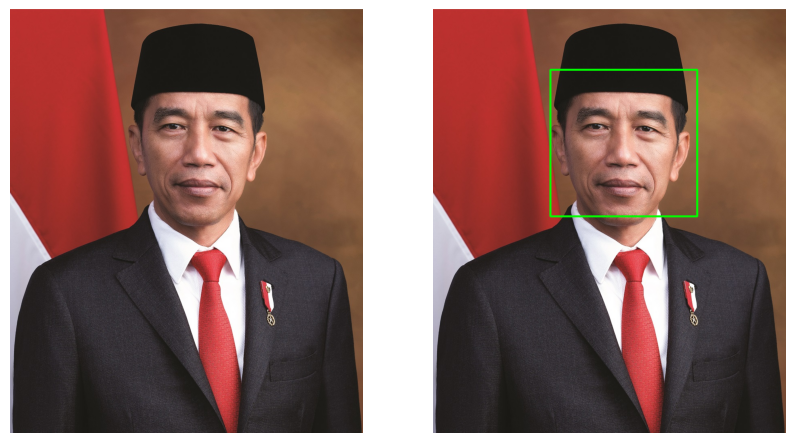

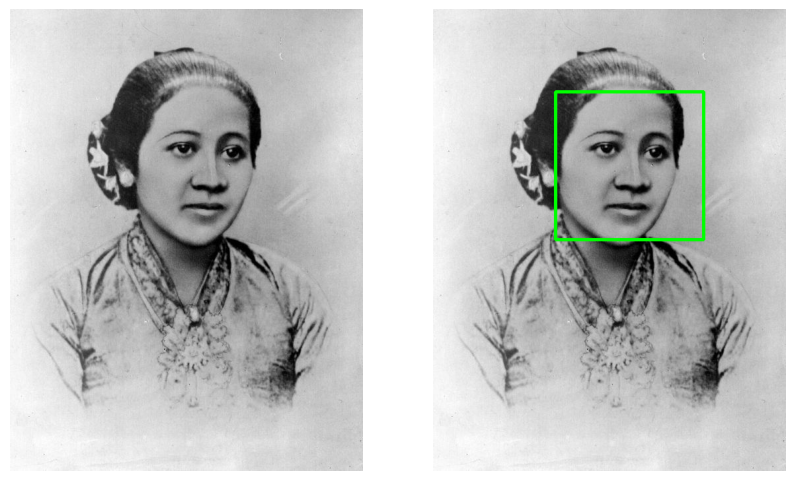

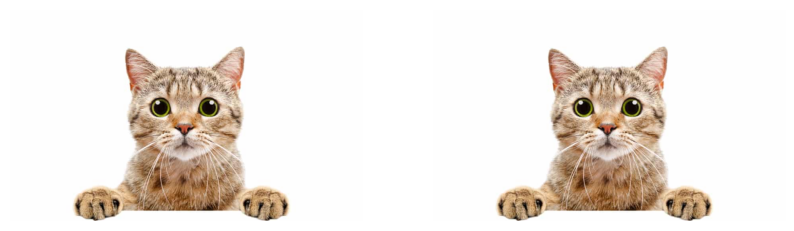

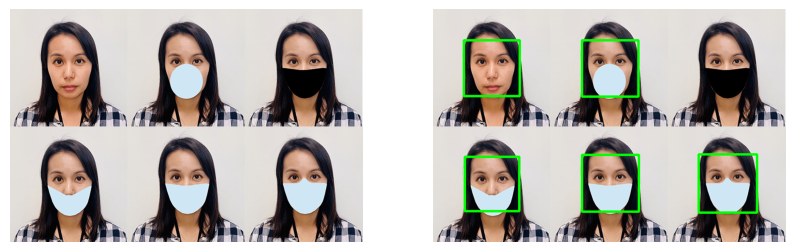

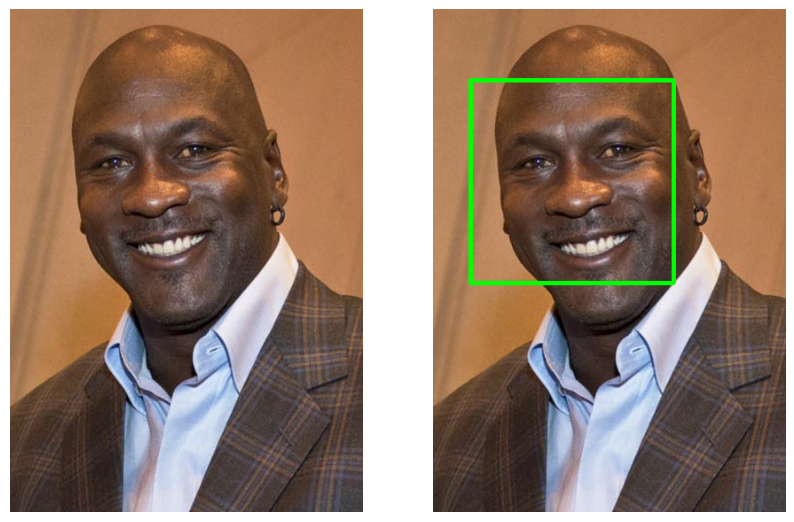

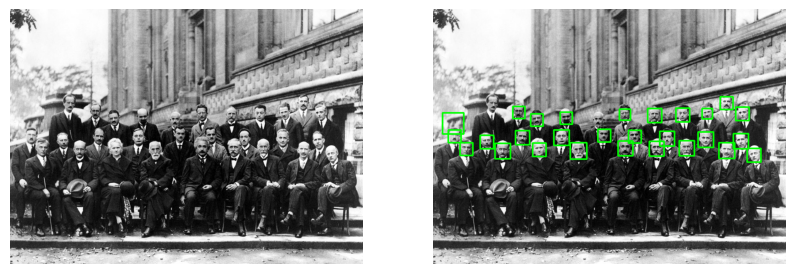

In [25]:
# Jokowi
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/jokowi.jpg')
# Kartini
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/kartini.jpg')
# Kucing
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/kucing.jpg')
# Mask
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/mask.png')
# Mjordan
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/mjordan.jpg')
# Solvayconf
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/solvayconf.jpg')

Pada Soal No.2. wajah kucing tidak bisa dideteksi dengan baik. Lakukan deteksi wajah
kucing hingga muncul rectangle pada bagian wajahnya. Petunjuk pada soal ini,
perhatikan pretrained features yang telah disediakan OpenCV. Gunakan xml yang ada
jika memang telah disediakan. Jika belum ada, coba cari dengan searching melalui
search engines.

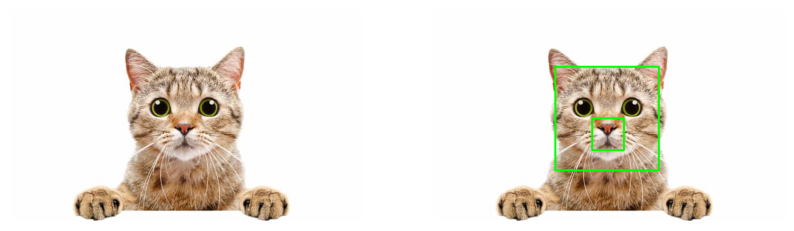

In [28]:
# Kucing
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/kucing.jpg','/content/drive/MyDrive/PCVK_MM/Images/Images/haarcascades/haarcascade_frontalcatface.xml')

Cobakan juga untuk eyes detection.

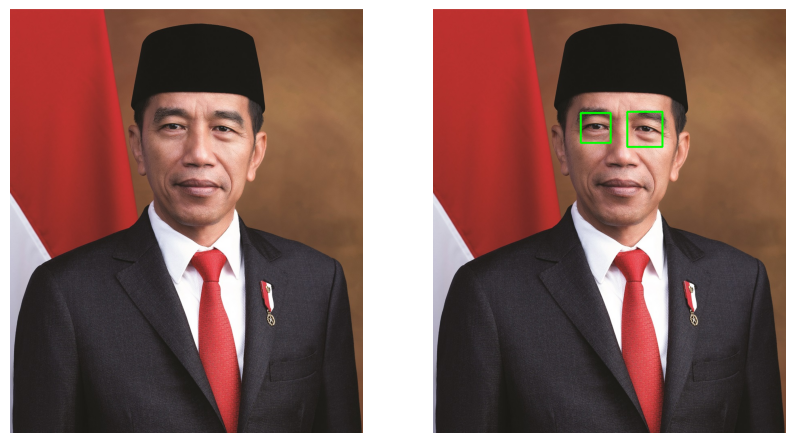

In [29]:
# Eyes Detection
detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/jokowi.jpg','/content/drive/MyDrive/PCVK_MM/Images/Images/haarcascades/haarcascade_eye.xml')

Lakukan Face Tracking menggunakan Google Colab.

In [55]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv.CascadeClassifier(cv.samples.findFile(cv.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [50]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [64]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

Lakukan Blurring pada bagian wajah yang terdeteksi.

In [67]:
def blur_detect_face(img_path, classifier = '/content/drive/MyDrive/PCVK_MM/Images/Images/haarcascades/haarcascade_frontalface_alt.xml'):
    cascade_wajah = cv.CascadeClassifier(classifier)
    img = cv.imread(img_path)
    img_copy = img.copy()
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    roi_wajah = cascade_wajah.detectMultiScale(gray)

    for (x, y, w, h) in roi_wajah:
        face_roi = img_copy[y:y+h, x:x+w]
        blurred_face = cv.GaussianBlur(face_roi, (99, 99), 30)
        img_copy[y:y+h, x:x+w] = blurred_face

    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis("off")

    plt.subplot(122)
    plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
    plt.title('Faces Blurred')
    plt.axis("off")

    plt.show()


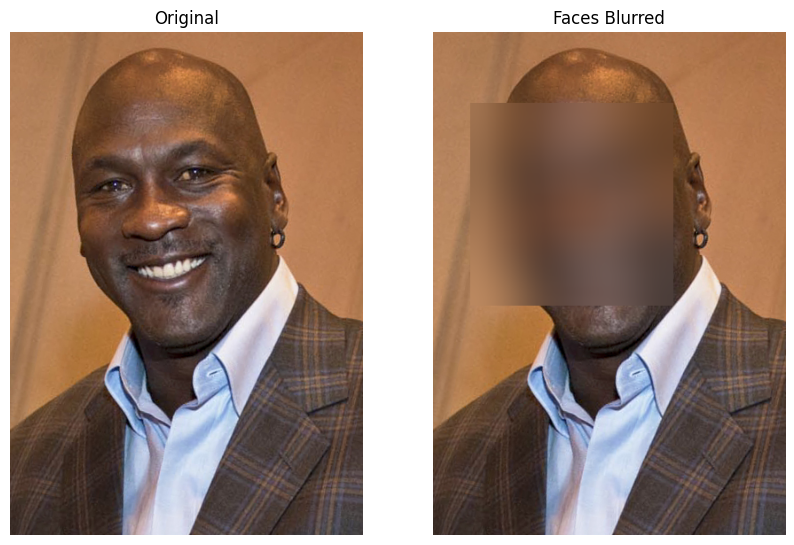

In [68]:
blur_detect_face('/content/drive/MyDrive/PCVK_MM/Images/Images/facedet/mjordan.jpg')